In [48]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F


from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 20

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 4

# Other
DEVICE = "cuda:0"#"cpu"#"cuda:1"
GRAYSCALE = True

CUDA available: True
Number of GPUs: 1
Current device: 0
Device name: NVIDIA RTX A4000


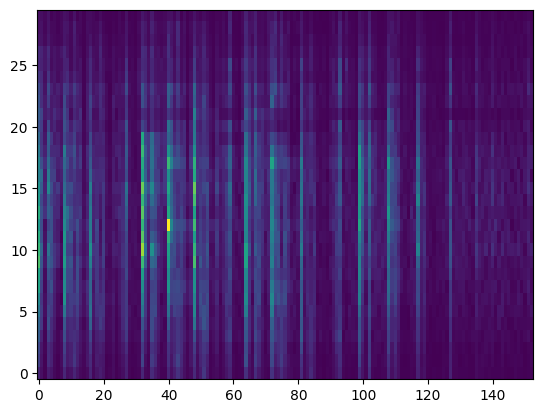

In [49]:
# Note transforms.ToTensor() scales input images
# to 0-1 range
fft_data_all = np.load('data/andy_practice/fft_data.npy')
fft_data_labels = np.load('data/andy_practice/labels.npy')

# only keeps the relevant part of the FFT, note this may change based on the 
# lower_freq_index = 115
# upper_freq_index = 145
# fft_data_clipped = np.transpose(fft_data_all[:,:,lower_freq_index:upper_freq_index])
fft_data_clipped = np.transpose(fft_data_all)

#load a single image as a sense check [x,y,n]
fft_data_single = fft_data_clipped[:,:,0]
plt.imshow(np.abs(fft_data_single), aspect='auto', cmap='viridis', origin='lower')

Image batch dimensions: torch.Size([32, 1, 30, 153])
Image label dimensions: torch.Size([32])


Text(0.5, 1.0, 'Label: 1')

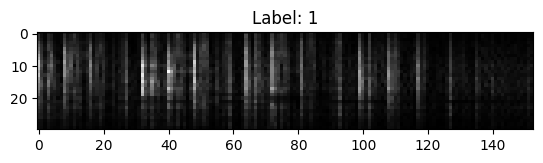

In [50]:
from torch.utils.data import Dataset, DataLoader, random_split

class SpectrogramDataset(Dataset):
    def __init__(self, data_path='data/andy_practice/fft_data.npy', labels_path='data/andy_practice/labels.npy', transform=None):
        self.data = np.load(data_path)  
        self.labels = np.load(labels_path)  # shape: [N]
        self.transform = transform
        self.data = np.transpose(self.data, (0,2,1)) # shape: [N, 35, 153]

        # Create mapping from label string to int
        unique_labels = sorted(set(self.labels))
        self.label2idx = {label: idx for idx, label in enumerate(unique_labels)}
        # Reverse the label2idx mapping to get the label from index
        self.idx2label = {idx: label for label, idx in self.label2idx.items()}  

        # Encode all labels
        self.encoded_labels = np.array([self.label2idx[label] for label in self.labels])

    def __len__(self):
        return len(self.encoded_labels)

    def __getitem__(self, idx):
        image = self.data[idx]  # shape: [40, 153]
        label = self.encoded_labels[idx]
        
        # Convert to PIL image-like shape and apply transform
        image = image.astype(np.float32)
        image = np.expand_dims(image, axis=0)  # shape: [1, 40, 153]
        #image = np.repeat(image, 3, axis=0)    # shape: [3, 40, 153] for ResNet-18

        if self.transform:
            image = self.transform(torch.from_numpy(image))
        else:
            image = torch.from_numpy(image)

        return image, int(label)
    
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Optional: ResNet expects 224x224
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Load full dataset
full_dataset = SpectrogramDataset(
    data_path='data/andy_practice/fft_data.npy',
    labels_path='data/andy_practice/labels.npy',
    transform=transform
)

# Set the split ratio
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split into train/test
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Select the first image in the batch
img = images[0]  # shape: [C, H, W]
img = img.squeeze().numpy()
label = labels[0]

plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
plt.title(f"Label: {label}")

In [51]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 32
Epoch: 2 | Batch index: 0 | Batch size: 32


# ResNet-18 Model

In [52]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(2560 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here, and my data is down to 1x
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model


In [53]:
torch.manual_seed(RANDOM_SEED)

model = resnet18(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

# Training

In [54]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/020 | Batch 0000/0100 | Cost: 1.7974
Epoch: 001/020 | Batch 0050/0100 | Cost: 1.5141
Epoch: 001/020 | Train: 25.062%
Time elapsed: 0.02 min
Epoch: 002/020 | Batch 0000/0100 | Cost: 1.5940
Epoch: 002/020 | Batch 0050/0100 | Cost: 1.3898
Epoch: 002/020 | Train: 25.031%
Time elapsed: 0.03 min
Epoch: 003/020 | Batch 0000/0100 | Cost: 0.0429
Epoch: 003/020 | Batch 0050/0100 | Cost: 0.0028
Epoch: 003/020 | Train: 25.031%
Time elapsed: 0.05 min
Epoch: 004/020 | Batch 0000/0100 | Cost: 0.0002
Epoch: 004/020 | Batch 0050/0100 | Cost: 0.0001
Epoch: 004/020 | Train: 25.031%
Time elapsed: 0.07 min
Epoch: 005/020 | Batch 0000/0100 | Cost: 0.0004
Epoch: 005/020 | Batch 0050/0100 | Cost: 0.0001
Epoch: 005/020 | Train: 25.062%
Time elapsed: 0.09 min
Epoch: 006/020 | Batch 0000/0100 | Cost: 0.4677
Epoch: 006/020 | Batch 0050/0100 | Cost: 0.0000
Epoch: 006/020 | Train: 25.062%
Time elapsed: 0.11 min
Epoch: 007/020 | Batch 0000/0100 | Cost: 0.0005
Epoch: 007/020 | Batch 0050/0100 | Cost: 0.046

In [55]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 70.75%


In [56]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

tensor([[6.9454e-13, 1.1450e-22, 1.0000e+00, 5.2119e-11]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Labels in dataset: {0: np.str_('air'), 1: np.str_('desk'), 2: np.str_('lunch'), 3: np.str_('soil')}
Predicted label: lunch


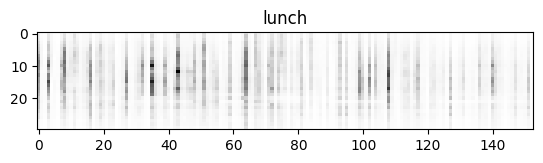

In [57]:
model.eval()

nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys')
label = full_dataset.idx2label[targets[0].item()]
plt.title(label)

logits, probas = model(features.to(device)[0, None])
print(probas)
# For a given prediction index (assuming it comes from your model's output)
print(f"Labels in dataset: {full_dataset.idx2label}")
predicted_class = torch.argmax(probas, dim=1).item()
predicted_label = full_dataset.idx2label[predicted_class]
print(f'Predicted label: {predicted_label}')

Actual label: lunch
Predicted label: lunch with 1.0 out of tensor([[6.9454e-13, 1.1450e-22, 1.0000e+00, 5.2119e-11]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>) 


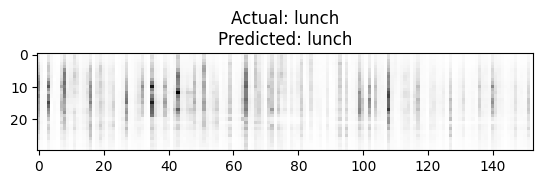

Actual label: desk
Predicted label: desk with 1.0 out of tensor([[1.4783e-05, 9.9999e-01, 1.9480e-11, 1.0708e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>) 


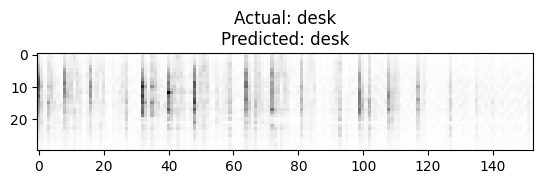

Actual label: air
Predicted label: air with 1.0 out of tensor([[1.0000e+00, 2.8256e-16, 3.1980e-11, 2.7393e-13]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>) 


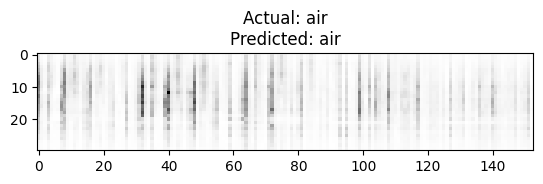

Actual label: soil
Predicted label: air with 0.999 out of tensor([[9.9863e-01, 4.5062e-11, 3.9994e-06, 1.3703e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>) 


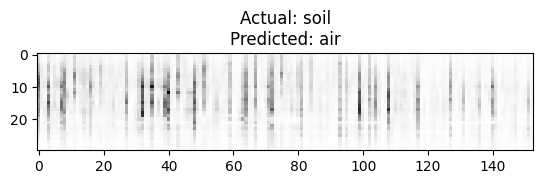

In [58]:
# Track which labels you've already processed
processed_labels = set()

# Loop through the data in test_loader
for batch_idx, (features, targets) in enumerate(test_loader):
    
    # Loop through the batch to find one image of each class
    for i in range(len(features)):
        label = targets[i].item()
        label_name = full_dataset.idx2label[label]

        # If we've already processed this label, skip this image
        if label_name in processed_labels:
            continue
        
        # Add the label to the set of processed labels
        processed_labels.add(label_name)

        # Get the image (NHWC format) and convert it to the correct format for plotting
        nhwc_img = np.transpose(features[i], axes=(1, 2, 0))  # Convert from NCHW to NHWC
        nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)  # Remove extra channel dimension if present

        # Display the image
        plt.imshow(nhw_img, cmap='Greys')

        # Get the actual label
        actual_label = full_dataset.idx2label[label]

        # Make prediction
        logits, probas = model(features.to(device)[i, None])  # Pass the image through the model
        predicted_class = torch.argmax(probas, dim=1).item()
        predicted_label = full_dataset.idx2label[predicted_class]

        # Print the actual and predicted labels
        print(f"Actual label: {actual_label}")
        print(f"Predicted label: {predicted_label} with {round(probas[0, predicted_class].item(), 3)} out of {probas} ")
        
        # Set the plot title to show the actual and predicted labels
        plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
        
        # Show the image
        plt.show()

        # Break the loop if all classes have been processed
        if len(processed_labels) == len(full_dataset.idx2label):
            break
    
    # Break the outer loop once all classes are processed
    if len(processed_labels) == len(full_dataset.idx2label):
        break


In [59]:
torch.save(model.state_dict(), "resnet_spectrogram_simple_4000_weights.pth")

In [60]:
torch.save(model, "resnet_spectrogram_simple_4000_full.pth")